## Imports

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
import datetime
import pickle
import warnings

## Read in csv files

In [2]:
all_hd = pd.read_csv('../data/interim/heart_disease_data_all_pt2.csv').drop('Unnamed: 0', axis=1)
cleveland_hd = pd.read_csv('../data/interim/heart_disease_data_cleveland_pt2.csv').drop('Unnamed: 0', axis=1)

## View data

In [3]:
all_hd.head()

,id,age,trestbps,chol,thalch,oldpeak,num,Male,chest_pain,high_fbs,abnormal_restecg,exercise_induced_angina
0,1,63,145.0,233.0,150.0,2.3,0,1,1,1,1,0
1,2,67,160.0,286.0,108.0,1.5,1,1,0,0,1,1
2,3,67,120.0,229.0,129.0,2.6,1,1,0,0,1,1
3,4,37,130.0,250.0,187.0,3.5,0,1,1,0,0,0
4,5,41,130.0,204.0,172.0,1.4,0,0,1,0,1,0


In [4]:
cleveland_hd.head()

,id,age,trestbps,chol,thalch,oldpeak,ca,num,Male,chest_pain,high_fbs,abnormal_restecg,exercise_induced_angina,upsloping,defect
0,1,63,145.0,233.0,150.0,2.3,0.0,0,1,1,1,1,0,0,1
1,2,67,160.0,286.0,108.0,1.5,3.0,1,1,0,0,1,1,0,0
2,3,67,120.0,229.0,129.0,2.6,2.0,1,1,0,0,1,1,0,1
3,4,37,130.0,250.0,187.0,3.5,0.0,0,1,1,0,0,0,0,0
4,5,41,130.0,204.0,172.0,1.4,0.0,0,0,1,0,1,0,1,0


## Split data into training and testing sets

In [5]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(all_hd.drop(columns=['num', 'id']), 
                                                    all_hd.num, test_size=0.3, 
                                                    random_state=47)

In [6]:
X_cleveland_train, X_cleveland_test, y_cleveland_train, y_cleveland_test = train_test_split(cleveland_hd.drop(columns=['num', 'id']), 
                                                    cleveland_hd.num, test_size=0.3, 
                                                    random_state=47)

## Naive Model

### All datasets

In [7]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_all_train, y_all_train)
y_pred = dummy.predict(X_all_test)
f1_score(y_all_test, y_pred)

0.7223587223587223

### Cleveland dataset

In [8]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_cleveland_train, y_cleveland_train)
y_pred = dummy.predict(X_cleveland_test)
f1_score(y_cleveland_test, y_pred)

0.6165413533834586

## Logistic Regression

### All datasets

In [9]:
pipe_log_reg_all = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    LogisticRegression()
)

In [10]:
grid_params = {
        'simpleimputer__strategy': ['mean', 'median'],
        'standardscaler': [StandardScaler(), MinMaxScaler(), None],
        'simpleimputer__strategy': ['mean', 'median'],
        'logisticregression__C': [0.01, 0.1, 1, 10, 100],
        'logisticregression__fit_intercept': [True, False],
        'logisticregression__l1_ratio': [0, .1, .25, .5, .75, 1],
        'logisticregression__penalty': ['elasticnet', None],
        'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [11]:
warnings.filterwarnings("ignore")
log_reg_all_grid_cv = GridSearchCV(pipe_log_reg_all, param_grid=grid_params, cv=5, n_jobs=-1, scoring='f1')
log_reg_all_grid_cv.fit(X_all_train, y_all_train)
print(log_reg_all_grid_cv.best_params_)
print(f'Best Score = {log_reg_all_grid_cv.best_score_}')

{'logisticregression__C': 0.01, 'logisticregression__fit_intercept': False, 'logisticregression__l1_ratio': 0, 'logisticregression__penalty': None, 'logisticregression__solver': 'lbfgs', 'simpleimputer__strategy': 'mean', 'standardscaler': MinMaxScaler()}
Best Score = 0.8321308241401686


### Cleveland dataset

In [12]:
pipe_log_reg_cleveland = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    LogisticRegression()
)

In [13]:
log_reg_cleveland_grid_cv = GridSearchCV(pipe_log_reg_cleveland, param_grid=grid_params, cv=5, n_jobs=-1, scoring='f1')
log_reg_cleveland_grid_cv.fit(X_cleveland_train, y_cleveland_train)
print(log_reg_cleveland_grid_cv.best_params_)
print(f'Best Score = {log_reg_cleveland_grid_cv.best_score_}')

{'logisticregression__C': 0.1, 'logisticregression__fit_intercept': False, 'logisticregression__l1_ratio': 0.75, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga', 'simpleimputer__strategy': 'median', 'standardscaler': StandardScaler()}
Best Score = 0.8685332744730163


## AdaBoost

### All datasets - Decision Tree Estimator

In [14]:
decision_tree = DecisionTreeClassifier()

pipe_adaboost_decision_tree_all = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    AdaBoostClassifier()
)

In [15]:
grid_params = {
    'adaboostclassifier__estimator': [decision_tree],
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__learning_rate': [.01, .25, .5, .75, 1],
    'adaboostclassifier__n_estimators': [100, 200, 300, 400, 500],
    'adaboostclassifier__estimator__ccp_alpha': [.001, .01, .1, .25],
    'adaboostclassifier__estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'adaboostclassifier__estimator__max_depth': [1, 2, 3, 4],
    'adaboostclassifier__estimator__max_features': [None, 'auto', 'sqrt', 'log2'], 
    'adaboostclassifier__estimator__min_impurity_decrease': [.0001, .001, .01, .1],
    'adaboostclassifier__estimator__min_samples_leaf': [1, 2, 3, 4, 5],
    'adaboostclassifier__estimator__min_samples_split': [2, 3, 4, 5],
    'adaboostclassifier__estimator__splitter': ['best', 'random']
}

In [16]:
adaboost_decision_tree_all_grid_cv = RandomizedSearchCV(pipe_adaboost_decision_tree_all, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
adaboost_decision_tree_all_grid_cv.fit(X_all_train, y_all_train)
print(adaboost_decision_tree_all_grid_cv.best_params_)
print(f'Best Score = {adaboost_decision_tree_all_grid_cv.best_score_}')

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'median', 'adaboostclassifier__n_estimators': 500, 'adaboostclassifier__learning_rate': 0.75, 'adaboostclassifier__estimator__splitter': 'random', 'adaboostclassifier__estimator__min_samples_split': 3, 'adaboostclassifier__estimator__min_samples_leaf': 4, 'adaboostclassifier__estimator__min_impurity_decrease': 0.01, 'adaboostclassifier__estimator__max_features': None, 'adaboostclassifier__estimator__max_depth': 1, 'adaboostclassifier__estimator__criterion': 'entropy', 'adaboostclassifier__estimator__ccp_alpha': 0.01, 'adaboostclassifier__estimator': DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=1,
                       min_impurity_decrease=0.01, min_samples_leaf=4,
                       min_samples_split=3, splitter='random'), 'adaboostclassifier__algorithm': 'SAMME'}
Best Score = 0.8296206368684063


### All datasets - SVM Estimator

In [17]:
svm = SVC(probability=True)

pipe_adaboost_svm_all = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    AdaBoostClassifier()
)

In [18]:
grid_params = {
    'adaboostclassifier__estimator': [svm],
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__learning_rate': [.01, .25, .5, .75, 1],
    'adaboostclassifier__n_estimators': [25, 50, 75, 100],
    'adaboostclassifier__estimator__C': [0.01, 0.1, 1],
    'adaboostclassifier__estimator__decision_function_shape': ['ovo', 'ovr'],
    'adaboostclassifier__estimator__gamma': ['scale', 'auto'],
    'adaboostclassifier__estimator__kernel': ['linear'],
    'adaboostclassifier__estimator__shrinking': [True, False]
}

In [19]:
adaboost_svm_all_rand_cv = RandomizedSearchCV(pipe_adaboost_svm_all, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
adaboost_svm_all_rand_cv.fit(X_all_train, y_all_train)
print(adaboost_svm_all_rand_cv.best_params_)
print(f'Best Score = {adaboost_svm_all_rand_cv.best_score_}')

{'standardscaler': StandardScaler(), 'simpleimputer__strategy': 'mean', 'adaboostclassifier__n_estimators': 50, 'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__estimator__shrinking': True, 'adaboostclassifier__estimator__kernel': 'linear', 'adaboostclassifier__estimator__gamma': 'auto', 'adaboostclassifier__estimator__decision_function_shape': 'ovo', 'adaboostclassifier__estimator__C': 1, 'adaboostclassifier__estimator': SVC(C=1, decision_function_shape='ovo', gamma='auto', kernel='linear',
    probability=True), 'adaboostclassifier__algorithm': 'SAMME'}
Best Score = 0.8307697145036727


### All datasets - Logistic Regression Estimator

In [20]:
logistic_regression = LogisticRegression()

pipe_adaboost_log_reg_all = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    AdaBoostClassifier()
)

In [21]:
grid_params = {
    'adaboostclassifier__estimator': [logistic_regression],
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__learning_rate': [.01, .25, .5, .75, 1],
    'adaboostclassifier__n_estimators': [100, 200, 300, 400, 500],
    'adaboostclassifier__estimator__C': [0.01, 0.1, 1, 10, 100, 100],
    'adaboostclassifier__estimator__fit_intercept': [True, False],
    'adaboostclassifier__estimator__l1_ratio': [0, .1, .25, .5, .75, 1],
    'adaboostclassifier__estimator__penalty': ['elasticnet', None],
    'adaboostclassifier__estimator__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [22]:
adaboost_log_reg_all_rand_cv = RandomizedSearchCV(pipe_adaboost_log_reg_all, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
adaboost_log_reg_all_rand_cv.fit(X_all_train, y_all_train)
print(adaboost_log_reg_all_rand_cv.best_params_)
print(f'Best Score = {adaboost_log_reg_all_rand_cv.best_score_}')

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'mean', 'adaboostclassifier__n_estimators': 300, 'adaboostclassifier__learning_rate': 0.25, 'adaboostclassifier__estimator__solver': 'newton-cg', 'adaboostclassifier__estimator__penalty': None, 'adaboostclassifier__estimator__l1_ratio': 0, 'adaboostclassifier__estimator__fit_intercept': False, 'adaboostclassifier__estimator__C': 0.01, 'adaboostclassifier__estimator': LogisticRegression(C=0.01, fit_intercept=False, l1_ratio=0, penalty=None,
                   solver='newton-cg'), 'adaboostclassifier__algorithm': 'SAMME.R'}
Best Score = 0.833031443704766


### Cleveland dataset - Decision Tree Estimator

In [23]:
decision_tree = DecisionTreeClassifier()

pipe_adaboost_decision_tree_cleveland = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    AdaBoostClassifier()
)

In [24]:
grid_params = {
    'adaboostclassifier__estimator': [decision_tree],
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__learning_rate': [.01, .25, .5, .75, 1],
    'adaboostclassifier__n_estimators': [100, 200, 300, 400, 500],
    'adaboostclassifier__estimator__ccp_alpha': [.001, .01, .1, .25],
    'adaboostclassifier__estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'adaboostclassifier__estimator__max_depth': [1, 2, 3, 4],
    'adaboostclassifier__estimator__max_features': [None, 'auto', 'sqrt', 'log2'], 
    'adaboostclassifier__estimator__min_impurity_decrease': [.0001, .001, .01, .1],
    'adaboostclassifier__estimator__min_samples_leaf': [1, 2, 3, 4, 5],
    'adaboostclassifier__estimator__min_samples_split': [2, 3, 4, 5],
    'adaboostclassifier__estimator__splitter': ['best', 'random']
}

In [25]:
adaboost_decision_tree_cleveland_rand_cv = RandomizedSearchCV(pipe_adaboost_decision_tree_cleveland, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
adaboost_decision_tree_cleveland_rand_cv.fit(X_cleveland_train, y_cleveland_train)
print(adaboost_decision_tree_cleveland_rand_cv.best_params_)
print(f'Best Score = {adaboost_decision_tree_cleveland_rand_cv.best_score_}')

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'median', 'adaboostclassifier__n_estimators': 500, 'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__estimator__splitter': 'best', 'adaboostclassifier__estimator__min_samples_split': 2, 'adaboostclassifier__estimator__min_samples_leaf': 3, 'adaboostclassifier__estimator__min_impurity_decrease': 0.1, 'adaboostclassifier__estimator__max_features': 'log2', 'adaboostclassifier__estimator__max_depth': 1, 'adaboostclassifier__estimator__criterion': 'gini', 'adaboostclassifier__estimator__ccp_alpha': 0.1, 'adaboostclassifier__estimator': DecisionTreeClassifier(ccp_alpha=0.1, max_depth=1, max_features='log2',
                       min_impurity_decrease=0.1, min_samples_leaf=3), 'adaboostclassifier__algorithm': 'SAMME.R'}
Best Score = 0.8723311244492246


### Cleveland dataset - SVM Estimator

In [26]:
svm = SVC(probability=True)

pipe_adaboost_svm_cleveland = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    AdaBoostClassifier()
)

In [27]:
grid_params = {
    'adaboostclassifier__estimator': [svm],
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__learning_rate': [.01, .25, .5, .75, 1],
    'adaboostclassifier__n_estimators': [25, 50, 75, 100],
    'adaboostclassifier__estimator__C': [0.01, 0.1, 1],
    'adaboostclassifier__estimator__decision_function_shape': ['ovo', 'ovr'],
    'adaboostclassifier__estimator__gamma': ['scale', 'auto'],
    'adaboostclassifier__estimator__kernel': ['linear'],
    'adaboostclassifier__estimator__shrinking': [True, False]
}

In [28]:
adaboost_svm_cleveland_rand_cv = RandomizedSearchCV(pipe_adaboost_svm_cleveland, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
adaboost_svm_cleveland_rand_cv.fit(X_cleveland_train, y_cleveland_train)
print(adaboost_svm_cleveland_rand_cv.best_params_)
print(f'Best Score = {adaboost_svm_cleveland_rand_cv.best_score_}')

{'standardscaler': StandardScaler(), 'simpleimputer__strategy': 'mean', 'adaboostclassifier__n_estimators': 25, 'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__estimator__shrinking': True, 'adaboostclassifier__estimator__kernel': 'linear', 'adaboostclassifier__estimator__gamma': 'auto', 'adaboostclassifier__estimator__decision_function_shape': 'ovr', 'adaboostclassifier__estimator__C': 1, 'adaboostclassifier__estimator': SVC(C=1, gamma='auto', kernel='linear', probability=True), 'adaboostclassifier__algorithm': 'SAMME'}
Best Score = 0.841983241983242


### Cleveland dataset - Logistic Regression Estimator

In [29]:
logistic_regression = LogisticRegression()

pipe_adaboost_log_reg_cleveland = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    AdaBoostClassifier()
)

In [30]:
grid_params = {
    'adaboostclassifier__estimator': [logistic_regression],
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'adaboostclassifier__algorithm': ['SAMME', 'SAMME.R'],
    'adaboostclassifier__learning_rate': [.01, .25, .5, .75, 1],
    'adaboostclassifier__n_estimators': [100, 200, 300, 400, 500],
    'adaboostclassifier__estimator__C': [0.01, 0.1, 1, 10, 100, 100],
    'adaboostclassifier__estimator__fit_intercept': [True, False],
    'adaboostclassifier__estimator__l1_ratio': [0, .1, .25, .5, .75, 1],
    'adaboostclassifier__estimator__penalty': ['elasticnet', None],
    'adaboostclassifier__estimator__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [31]:
adaboost_log_reg_cleveland_rand_cv = RandomizedSearchCV(pipe_adaboost_log_reg_cleveland, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
adaboost_log_reg_cleveland_rand_cv.fit(X_cleveland_train, y_cleveland_train)
print(adaboost_log_reg_cleveland_rand_cv.best_params_)
print(f'Best Score = {adaboost_log_reg_cleveland_rand_cv.best_score_}')

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'mean', 'adaboostclassifier__n_estimators': 100, 'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__estimator__solver': 'newton-cg', 'adaboostclassifier__estimator__penalty': None, 'adaboostclassifier__estimator__l1_ratio': 1, 'adaboostclassifier__estimator__fit_intercept': False, 'adaboostclassifier__estimator__C': 1, 'adaboostclassifier__estimator': LogisticRegression(C=1, fit_intercept=False, l1_ratio=1, penalty=None,
                   solver='newton-cg'), 'adaboostclassifier__algorithm': 'SAMME'}
Best Score = 0.8611408916286966


## Random Forest

### All datasets

In [32]:
pipe_random_forest_all = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    RandomForestClassifier()
)

In [33]:
grid_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__ccp_alpha': [.0001, .001, .01, .1],
    'randomforestclassifier__criterion': ["gini", "entropy", "log_loss"],
    'randomforestclassifier__max_depth': [3, 5, 10, 20, None],
    'randomforestclassifier__max_features': ["sqrt", "log2", None],
    'randomforestclassifier__max_leaf_nodes': [10, 20, 50, 100, 200, None],
    'randomforestclassifier__min_impurity_decrease': [0, .0001, .001, .01, .1],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500],
    'randomforestclassifier__n_jobs': [-1]
}

In [34]:
random_forest_all_grid_cv = RandomizedSearchCV(pipe_random_forest_all, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
random_forest_all_grid_cv.fit(X_all_train, y_all_train)
print(random_forest_all_grid_cv.best_params_)
print(f'Best Score = {random_forest_all_grid_cv.best_score_}')

{'standardscaler': None, 'simpleimputer__strategy': 'median', 'randomforestclassifier__n_jobs': -1, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__min_impurity_decrease': 0.01, 'randomforestclassifier__max_leaf_nodes': 10, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__ccp_alpha': 0.001, 'randomforestclassifier__bootstrap': False}
Best Score = 0.8367297951196463


### Cleveland

In [35]:
pipe_random_forest_cleveland = make_pipeline(
    SimpleImputer(), 
    StandardScaler(),
    RandomForestClassifier()
)

In [36]:
grid_params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'standardscaler': [StandardScaler(), MinMaxScaler(), None],
    'randomforestclassifier__bootstrap': [True, False],
    'randomforestclassifier__ccp_alpha': [.0001, .001, .01, .1],
    'randomforestclassifier__criterion': ["gini", "entropy", "log_loss"],
    'randomforestclassifier__max_depth': [3, 5, 10, 20, None],
    'randomforestclassifier__max_features': ["sqrt", "log2", None],
    'randomforestclassifier__max_leaf_nodes': [10, 20, 50, 100, 200, None],
    'randomforestclassifier__min_impurity_decrease': [0, .0001, .001, .01, .1],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500],
    'randomforestclassifier__n_jobs': [-1]
}

In [37]:
random_forest_cleveland_rand_cv = RandomizedSearchCV(pipe_random_forest_cleveland, param_distributions=grid_params, 
                                               cv=5, n_jobs=-1, n_iter = 180, scoring='f1')
random_forest_cleveland_rand_cv.fit(X_cleveland_train, y_cleveland_train)
print(random_forest_cleveland_rand_cv.best_params_)
print(f'Best Score = {random_forest_cleveland_rand_cv.best_score_}')

{'standardscaler': MinMaxScaler(), 'simpleimputer__strategy': 'median', 'randomforestclassifier__n_jobs': -1, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_impurity_decrease': 0.001, 'randomforestclassifier__max_leaf_nodes': 200, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__criterion': 'log_loss', 'randomforestclassifier__ccp_alpha': 0.001, 'randomforestclassifier__bootstrap': True}
Best Score = 0.855109725109725


In [38]:
warnings.resetwarnings()

## Final Model Selection

In [39]:
def f1_score_output(model, X_train, X_test, y_train, y_test):
    f1 = cross_validate(model.best_estimator_, X_train, y_train, scoring='f1', cv=5, n_jobs=-1)
    f1_mean = np.mean(f1['test_score'])
    f1_std = np.std(f1['test_score'])
    print('Cross-Validation (Training Data)')
    print(f1_mean, f1_std)
    print('Test Score')
    print(f1_score(y_test, model.best_estimator_.predict(X_test)))

## All datasets

### Logistic Regression

In [40]:
f1_score_output(log_reg_all_grid_cv, X_all_train, X_all_test, y_all_train, y_all_test)

Cross-Validation (Training Data)
0.8321308241401686 0.011462114460607565
Test Score
0.8222996515679442


### Adaboost - Decision Tree Estimator

In [41]:
f1_score_output(adaboost_decision_tree_all_grid_cv, X_all_train, X_all_test, y_all_train, y_all_test)

Cross-Validation (Training Data)
0.8132734673167408 0.02176023438202022
Test Score
0.8395904436860068


### Adaboost - SVM Estimator

In [42]:
f1_score_output(adaboost_svm_all_rand_cv, X_all_train, X_all_test, y_all_train, y_all_test)

Cross-Validation (Training Data)
0.8307697145036727 0.006113140812865606
Test Score
0.825938566552901


### Adaboost - Logistic Regression Estimator

In [43]:
f1_score_output(adaboost_log_reg_all_rand_cv, X_all_train, X_all_test, y_all_train, y_all_test)

Cross-Validation (Training Data)
0.833031443704766 0.01365310187104873
Test Score
0.8111888111888111


### Random Forest

In [44]:
f1_score_output(random_forest_all_grid_cv, X_all_train, X_all_test, y_all_train, y_all_test)

Cross-Validation (Training Data)
0.8298693140747764 0.01429095043444617
Test Score
0.7973421926910299


## Cleveland

### Logistic Regression

In [45]:
f1_score_output(log_reg_cleveland_grid_cv, X_cleveland_train, X_cleveland_test, y_cleveland_train, y_cleveland_test)

Cross-Validation (Training Data)
0.8685332744730163 0.04178642694731104
Test Score
0.7749999999999999


### Adaboost - Decision Tree Estimator

In [46]:
f1_score_output(adaboost_decision_tree_cleveland_rand_cv, X_cleveland_train, X_cleveland_test, 
                y_cleveland_train, y_cleveland_test)

Cross-Validation (Training Data)
0.8538458869652708 0.05956714410802703
Test Score
0.6575342465753423


### Adaboost - SVM Estimator

In [47]:
f1_score_output(adaboost_svm_cleveland_rand_cv, X_cleveland_train, X_cleveland_test, y_cleveland_train, y_cleveland_test)

Cross-Validation (Training Data)
0.841983241983242 0.03263170714344497
Test Score
0.7945205479452054


### Adaboost - Logistic Regression Estimator

In [48]:
f1_score_output(adaboost_log_reg_cleveland_rand_cv, X_cleveland_train, X_cleveland_test, 
                y_cleveland_train, y_cleveland_test)

Cross-Validation (Training Data)
0.8611408916286966 0.026783020433527167
Test Score
0.7466666666666667


### Random Forest

In [49]:
f1_score_output(random_forest_cleveland_rand_cv, X_cleveland_train, X_cleveland_test, y_cleveland_train, y_cleveland_test)

Cross-Validation (Training Data)
0.8368680445151032 0.035705022942275275
Test Score
0.7532467532467532


## Results

Overall, the best performing model was the adaboost with decision tree estimator. This model had an F1 score of about .84 on the test set. The models trained on the Cleveland only datasets were overfit so I will only be using this one model moving forward.

### Feature Importances

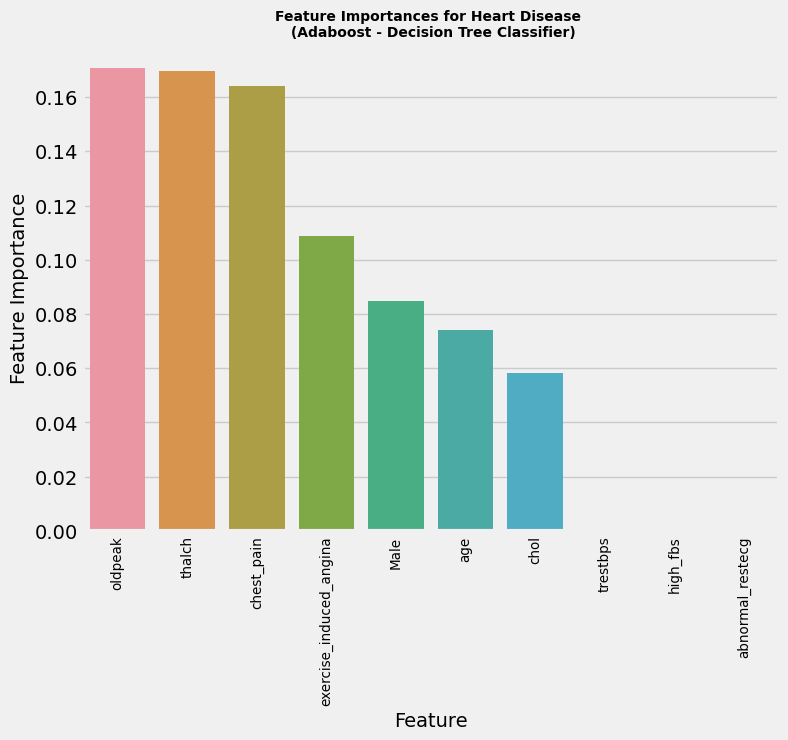

In [54]:
plt.style.use('fivethirtyeight')

features = adaboost_decision_tree_all_grid_cv.best_estimator_[:-1].get_feature_names_out()
feature_importances = adaboost_decision_tree_all_grid_cv.best_estimator_.named_steps.adaboostclassifier.feature_importances_
feature_importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)

feature_importances = feature_importances.reset_index()
feature_importances.columns = ['Feature', 'Feature Importance']

plt.figure(figsize=(8, 6))

bar_plot = sns.barplot(x='Feature', y='Feature Importance', data=feature_importances)

_ = plt.title('Feature Importances for Heart Disease \n (Adaboost - Decision Tree Classifier)', 
              fontsize=10, fontweight='bold')
_ = plt.xlabel('Feature')
_ = plt.xticks(rotation=90, fontsize='x-small')
_ = plt.ylabel('Feature Importance')

The decision tree estimator in the model gave some insight into which features were most important in classifying the patients. ST depression induced by exercise relative to rest (oldpeak) was the most important factor, followed by maximum heart rate achieved (thalch), and whether or not the patient experienced chest pain. Exercise induced angina, sex, age, and cholesterol were also important factors.

## Save Model

In [55]:
best_model = adaboost_decision_tree_all_grid_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_all_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [56]:
with open('../models/best_model.pickle', 'wb') as handle:
    pickle.dump(best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

data = {'X_train': X_all_train, 'y_train': y_all_train, 'X_test': X_all_test, 'y_test': y_all_test}

with open('../data/processed/test_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)